# Pipeline --> data ingestor

making the pipeline work to download 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read data Provided

In [4]:
# read data
df_bt = pd.read_json('./aggr/Building_Terni.json')

In [8]:
bt = df_bt
timestamp = bt["Year"].astype(str) + "-" + bt["Month"].astype(str) + "-" + bt["Day"].astype(str) + " " + bt["Timestamp"].dt.hour.astype(str) + ":" + bt["Timestamp"].dt.minute.astype(str) + ":" + bt["Timestamp"].dt.second.astype(str)
res = pd.to_datetime(timestamp,
               format='%Y-%m-%d %H:%M:%S')
bt.loc[:, 'Timestamp'] = res
bt = bt.drop(columns=['Year', 'Month', 'Day', 'Energy (Wh)'])
bt.set_index('Timestamp', inplace=True)

# add new columns

# normalize
bt = bt.astype(float)
#bt = bt.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))

bt.rename(columns={'Power (W)':'Consumed Power (W)'}, inplace=True)

bt.head()


,Consumed Power (W)
Timestamp,
2018-06-12 14:20:00,59293.4
2018-06-12 14:30:00,25377.2
2018-06-12 14:40:00,22612.7
2018-06-12 14:50:00,22534.2
2018-06-12 15:00:00,20747.9


In [10]:
# read data
df_pt = pd.read_json('./aggr/Photovoltaic_Terni.json')

In [12]:
pt = df_pt
timestamp = pt["Year"].astype(str) + "-" + pt["Month"].astype(str) + "-" + pt["Day"].astype(str) + " " + pt["Timestamp"].dt.hour.astype(str) + ":" + pt["Timestamp"].dt.minute.astype(str) + ":" + pt["Timestamp"].dt.second.astype(str)
res = pd.to_datetime(timestamp,
               format='%Y-%m-%d %H:%M:%S')
pt.loc[:, 'Timestamp'] = res
pt = pt.drop(columns=['Year', 'Month', 'Day'])
pt.set_index('Timestamp', inplace=True)

pt.rename(columns={'Power (W)':'Produced Power (W)'}, inplace=True)

pt = pt.astype(float)
#pt = pt.apply(lambda x: 1-(x - np.min(x)) / (np.max(x) - np.min(x)))
pt = pt.apply(lambda x: (np.max(x) - x))

pt.head()

,Produced Power (W)
Timestamp,
2018-08-01 01:00:00,3840.46352
2018-08-01 01:10:00,3840.46609
2018-08-01 01:20:00,3840.46651
2018-08-01 01:30:00,3840.46493
2018-08-01 01:40:00,3840.46638


## Read Irradiance

In [13]:
import json

# read data
with open('./aggr/irradiance.json') as f:
    data = json.load(f)

dr = pd.json_normalize(data['outputs']['hourly'])
res = pd.to_datetime(dr['time'],
               format='%Y%m%d:%H%M')
dr.loc[:, 'time'] = res
dr.set_index('time', inplace=True)
dr.index.rename('Timestamp', inplace=True)

dr.drop(columns=['Gr(i)', 'WS10m', 'Int', 'P'], inplace=True)

# normalize
#dr = (dr - dr.mean()) / dr.std()
dr=(dr-dr.min())/(dr.max()-dr.min())

dr.head()
    

,Gb(i),Gd(i),H_sun,T2m
Timestamp,,,,
2018-01-01 00:10:00,0.0,0.0,0.0,0.517677
2018-01-01 01:10:00,0.0,0.0,0.0,0.518855
2018-01-01 02:10:00,0.0,0.0,0.0,0.520034
2018-01-01 03:10:00,0.0,0.0,0.0,0.517845
2018-01-01 04:10:00,0.0,0.0,0.0,0.512626


## Join the data

In [14]:
res = bt.join(pt)
res = res.join(dr)
# remove all rows with missing values
res = res.dropna()

print(res)

                     Consumed Power (W)  Produced Power (W)     Gb(i)  \
Timestamp                                                               
2018-08-01 01:10:00             63239.1          3840.46609  0.000000   
2018-08-01 02:10:00             61292.5          3840.46509  0.000000   
2018-08-01 03:10:00             61249.6          3840.45602  0.000000   
2018-08-01 04:10:00             61852.0          3840.45472  0.000000   
2018-08-01 05:10:00            120076.0          3840.45837  0.308026   
...                                 ...                 ...       ...   
2019-07-31 20:10:00             78275.5          3805.33990  0.000000   
2019-07-31 21:10:00             65424.1          3805.91560  0.000000   
2019-07-31 22:10:00             64589.2          3805.66990  0.000000   
2019-07-31 23:10:00             62971.2          3806.24490  0.000000   
2019-08-01 00:10:00             62742.8          3805.96190  0.000000   

                        Gd(i)     H_sun       T2m 

# GRAPHHH TIMEEE

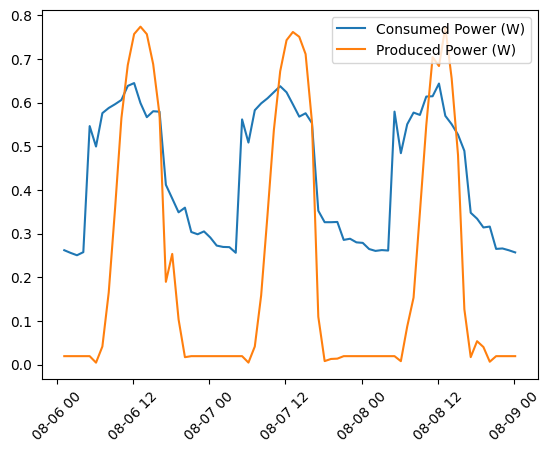

In [39]:
n_hours = 24
rate = 1
days = 3

plus_days = 5

plt.plot(res["Consumed Power (W)"][plus_days*rate*24:plus_days*rate*24 + (days*n_hours*rate)])
plt.plot(res["Produced Power (W)"][plus_days*rate*24:plus_days*rate*24 + (days*n_hours*rate)])

plt.xticks( rotation=45 )

plt.legend(["Consumed Power (W)", "Produced Power (W)"])


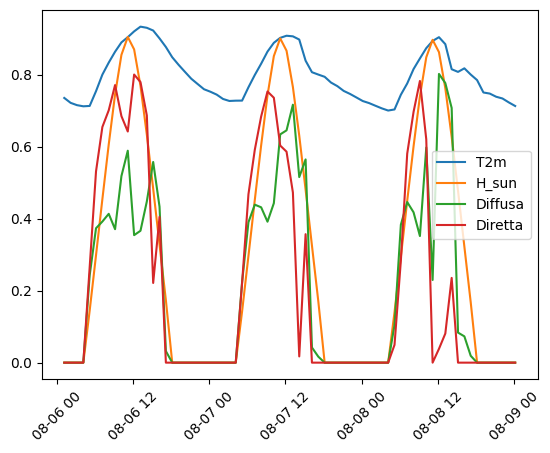

In [40]:
plt.plot(res["T2m"][plus_days*rate*24:plus_days*rate*24 + (days*n_hours*rate)])
plt.plot(res["H_sun"][plus_days*rate*24:plus_days*rate*24 + (days*n_hours*rate)])
plt.plot(res["Gd(i)"][plus_days*rate*24:plus_days*rate*24 + (days*n_hours*rate)])
plt.plot(res["Gb(i)"][plus_days*rate*24:plus_days*rate*24 + (days*n_hours*rate)])

# vertical timestamp lines
plt.xticks( rotation=45 )

plt.legend(["T2m", "H_sun", "Diffusa", "Diretta"])

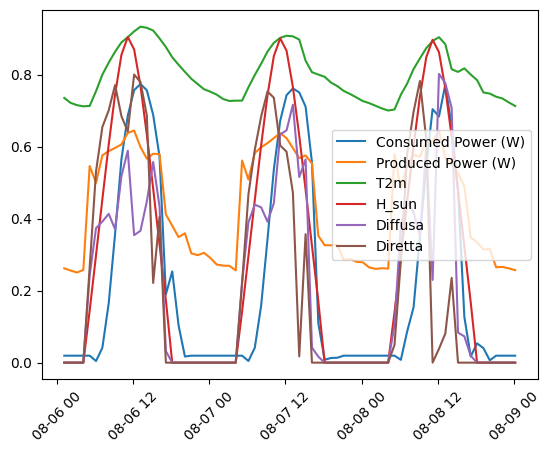

In [37]:
n_hours = 24
rate = 1
days = 3

plus_days = 5

plt.plot(res["Produced Power (W)"][plus_days*rate*24:plus_days*rate*24 + (days*n_hours*rate)])
plt.plot(res["Consumed Power (W)"][plus_days*rate*24:plus_days*rate*24 + (days*n_hours*rate)])
plt.plot(res["T2m"][plus_days*rate*24:plus_days*rate*24 + (days*n_hours*rate)])
plt.plot(res["H_sun"][plus_days*rate*24:plus_days*rate*24 + (days*n_hours*rate)])
plt.plot(res["Gd(i)"][plus_days*rate*24:plus_days*rate*24 + (days*n_hours*rate)])
plt.plot(res["Gb(i)"][plus_days*rate*24:plus_days*rate*24 + (days*n_hours*rate)])

# vertical timestamp lines
plt.xticks( rotation=45 )

plt.legend(["Consumed Power (W)", "Produced Power (W)", "T2m", "H_sun", "Diffusa", "Diretta"])

In [15]:
# save the data

# save json file
res.loc[:, 'date'] = res.index
res.to_json('data_non.json', orient="records")

In [38]:
# save the data

# save json file
res.loc[:, 'date'] = res.index
res.to_json('data_time.json', orient="records")

In [163]:
# save json file
data = res.copy()
data.reset_index(drop=True, inplace=True)
data.drop(columns=['date'], inplace=True)
data.to_json('data.json', orient="records")